In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/tsla_lstm

/content/drive/My Drive/tsla_lstm


In [4]:
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from lstm_model import build_lstm, preprocess_data 
import pickle, time
#---------------------------------------------
#
#   DATA PREPROCESS
#
# preprocess data from the file downloaded
# and get training data
file_name = 'TSLA.csv'
scaler_name = 'minmax' #'standard'
n_steps = 20  # window size
lookup_step = 1
test_size = 0.2 # 20% of data will be used for test

data = preprocess_data(file_name, scaler_name, n_steps, lookup_step, test_size)
print('data.keys() =', data.keys())
x_train, y_train = data['x_train'], data['y_train'] 
x_test, y_test = data['x_test'], data['y_test']
print('x_train.shape =', x_train.shape)
print('x_test.shape =', x_test.shape)
feats = data['feats']
n_feats = len(feats)
print(n_feats)

#---------------------------------------------
#   create training/validation data set
k = 3; # imagine 3-fold cross-validation
idx = np.random.choice(len(y_train),int(len(y_train)/k))
print('len(idx) =', len(idx))

x_val = x_train[idx]
y_val = y_train[idx]
print('x_val.shape =', x_val.shape)
print('y_val.shape =', x_val.shape)

idx_all = np.arange(len(y_train))
idx_left = set(idx_all) - set(idx)
idx_left = np.array(list(idx_left))

x_train = x_train[idx_left]
y_train = y_train[idx_left]
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)


feats = Index(['open', 'high', 'low', 'close', 'adjclose', 'volume'], dtype='object')
data.keys() = dict_keys(['feats', 'df', 'scaler', 'seq_last', 'x_train', 'x_test', 'y_train', 'y_test'])
x_train.shape = (2040, 20, 6)
x_test.shape = (510, 20, 6)
6
len(idx) = 680
x_val.shape = (680, 20, 6)
y_val.shape = (680, 20, 6)
x_train.shape = (1463, 20, 6)
y_train.shape = (1463,)


In [5]:
#--------------------------------------------
#
#   TRAIN
#
# Construct Lstm model
# Train and save callbacks : 
#date_now = time.strftime("%Y-%m-%d")
ticker = 'TSLA' ; loss = 'mse'
model_name = f"{ticker}-{loss}-seq-{n_steps}-step-{lookup_step}"

model = build_lstm(n_steps, n_feats)
model.summary()

# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
    

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
#early_stopping = EarlyStopping(patience = 20)
hist = model.fit(x_train, y_train, batch_size=128, epochs=300,
                validation_data=(x_val, y_val),
                callbacks=[checkpointer, tensorboard],verbose=1)

model.save(os.path.join("results", model_name) + ".h5")
results = model.evaluate(x_test, y_test, batch_size=128)

# save hist to history.pkl
f = open('history.pkl', 'wb')
pickle.dump(hist.history, f)
f.close()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4992      
_________________________________________________________________
dropout (Dropout)            (None, 20, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

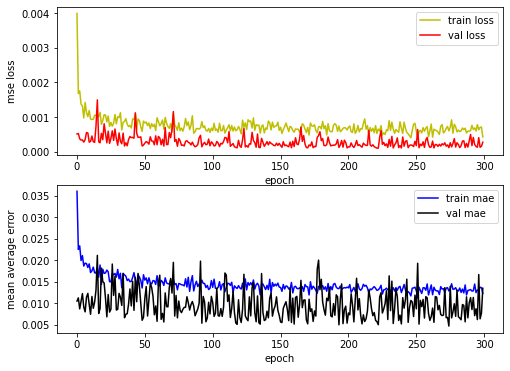

In [6]:
# plot loss and mae
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.plot(hist.history['loss'], 'y', label='train loss')
ax1.plot(hist.history['val_loss'], 'r', label='val loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('mse loss')
ax1.legend(loc='upper right')

ax2.plot(hist.history['mae'], 'b', label='train mae')
ax2.plot(hist.history['val_mae'], 'k', label='val mae')
ax2.set_xlabel('epoch')
ax2.set_ylabel('mean average error')
ax2.legend(loc='upper right')

plt.show()


In [7]:
from lstm_predict import predict_price, plot_prices, get_accuracy
# evaluate the model
mse, mae = model.evaluate(data['x_test'], data['y_test'], verbose=0)
# calculate the mean absolute error (inverse scaling)
scale = data['scaler']
mean_absolute_error = scale['adjclose'].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)


future_price = predict_price(model, data, n_steps)
print(f"Future price {lookup_step} - day(s) ahead is {future_price:.2f}$")



#---------------------------------------------------
# i day(s) ahead prediction of price
for i in [1,10,30,60]:
    print(str(i) + " day(s) ahead :", "Accuracy Score:", get_accuracy(model, data, i))



/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Mean Absolute Error: 10.156302488509171
Future price 1 - day(s) ahead is 362.82$
1 day(s) ahead : Accuracy Score: 0.9115913555992141
10 day(s) ahead : Accuracy Score: 0.912
30 day(s) ahead : Accuracy Score: 0.9166666666666666
60 day(s) ahead : Accuracy Score: 0.9066666666666666


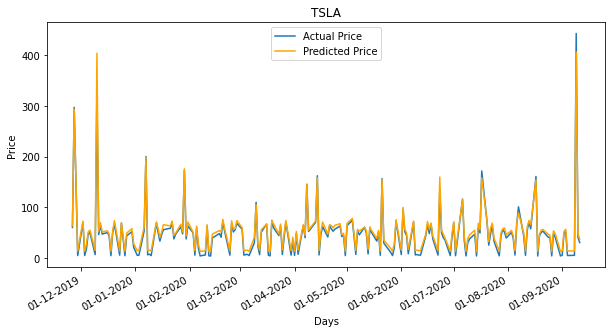

In [8]:
#---------------------------------------------------
# Predict the prices by last n_days
n_days = 200
plot_prices(model, data, n_days)